In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

print(torch.__version__)

# Set device and verify CUDA availability
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

2.6.0+cu118
CUDA available: True
CUDA version: 11.8
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070
Using device: cuda


In [2]:
data_path = 'data/multi_cancer/Multi Cancer/Multi Cancer'

# Load images (e.g., .jpg, .png) recursively and group as dict[top_level][subfolder] -> [images]
def load_images(data_path, target_size=(224, 224), max_per_folder=None, as_numpy=True, recursive=True):
    """
    Load images from each TOP-LEVEL subfolder under data_path and preserve subfolder names that contain images.

    Returns: Dict[str, Dict[str, List[np.ndarray|PIL.Image]]]
        {
          top_level_folder: {
              subfolder_path_relative_to_top: [images ...]  # only subfolders that actually contain images
          },
          ...
        }

    Notes:
    - Recursively walks through nested subdirectories inside each top-level folder when `recursive=True`.
    - Images are converted to RGB and resized to target_size if provided.
    - If as_numpy=True, items are numpy arrays (H, W, 3); otherwise PIL Images.
    - `max_per_folder` limits how many images to load per subfolder group (leaf that contains images).
    """
    from PIL import Image
    data = {}
    if not os.path.isdir(data_path):
        raise FileNotFoundError(f"Data path does not exist: {data_path}")

    allowed_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    for top_folder in os.listdir(data_path):
        top_folder_path = os.path.join(data_path, top_folder)
        if not os.path.isdir(top_folder_path):
            continue

        subdict = {}

        if recursive:
            walker = os.walk(top_folder_path)
            walk_iter = ((root, files) for root, _dirs, files in walker)
        else:
            files = os.listdir(top_folder_path)
            walk_iter = ((top_folder_path, files),)

        for root, files in walk_iter:
            # Filter image files in this root
            img_files = [f for f in files if f.lower().endswith(allowed_ext)]
            if len(img_files) == 0:
                continue

            images = []
            loaded_count = 0
            for f in img_files:
                file_path = os.path.join(root, f)
                try:
                    with Image.open(file_path) as img:
                        img = img.convert('RGB')
                        if target_size is not None:
                            img = img.resize(target_size, Image.BILINEAR)
                        images.append(np.array(img) if as_numpy else img.copy())
                        loaded_count += 1
                except Exception as e:
                    print(f"Warning: failed to load {file_path}: {e}")
                    continue

                if isinstance(max_per_folder, int) and max_per_folder > 0 and loaded_count >= max_per_folder:
                    break

            if len(images) == 0:
                continue

            # Compute subfolder key relative to the top-level folder
            rel_sub = os.path.relpath(root, top_folder_path).replace('\\', '/')
            if rel_sub == '.':
                rel_sub = '(root)'

            subdict[rel_sub] = images

        if len(subdict) == 0:
            print(f"Warning: no image files found under {top_folder_path} (recursive={recursive}); skipping.")
            continue

        data[top_folder] = subdict
    return data

# Load the images (recursive)
data = load_images(data_path, target_size=(224, 224), max_per_folder=None, as_numpy=True, recursive=True)
list(data.keys()) if isinstance(data, dict) else type(data)

['ALL',
 'Brain Cancer',
 'Breast Cancer',
 'Cervical Cancer',
 'Kidney Cancer',
 'Lung and Colon Cancer',
 'Lymphoma',
 'Oral Cancer']

In [3]:
# Summarize loaded image data by folder/subfolder
def summarize_data(data):
    if not isinstance(data, dict) or len(data) == 0:
        print("No data loaded or unexpected format.")
        return
    summary = {}
    for top, subdict in data.items():
        if not isinstance(subdict, dict):
            summary[top] = {"type": type(subdict).__name__}
            continue
        folder_summary = {}
        for sub, imgs in subdict.items():
            if isinstance(imgs, list) and len(imgs) > 0:
                shapes = [np.array(im).shape for im in imgs[:3]]
                folder_summary[sub] = {
                    "count": len(imgs),
                    "example_shapes": shapes + (["..."] if len(imgs) > 3 else [])
                }
            else:
                folder_summary[sub] = {"type": type(imgs).__name__, "count": len(imgs) if hasattr(imgs, '__len__') else None}
        summary[top] = folder_summary
    return summary

summarize_data(data)

{'ALL': {'all_benign': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']},
  'all_early': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']},
  'all_pre': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']},
  'all_pro': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']}},
 'Brain Cancer': {'brain_glioma': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']},
  'brain_menin': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']},
  'brain_tumor': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']}},
 'Breast Cancer': {'breast_benign': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224, 224, 3), '...']},
  'breast_malignant': {'count': 5000,
   'example_shapes': [(224, 224, 3), (224, 224, 3), (224

In [4]:
data['ALL'].keys()

dict_keys(['all_benign', 'all_early', 'all_pre', 'all_pro'])

In [5]:
import cv2

# resize all images to 224x224
for top, subdict in data.items():
    for sub, imgs in subdict.items():
        resized_imgs = []
        for img in imgs:
            resized_img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
            resized_imgs.append(resized_img)
        data[top][sub] = resized_imgs

data['ALL']

{'all_benign': [array([[[130, 144, 171],
          [130, 144, 173],
          [130, 143, 176],
          ...,
          [194, 211, 236],
          [193, 210, 239],
          [193, 209, 242]],
  
         [[131, 145, 172],
          [131, 145, 174],
          [131, 144, 177],
          ...,
          [194, 211, 237],
          [193, 210, 239],
          [192, 209, 241]],
  
         [[135, 149, 176],
          [135, 149, 178],
          [135, 148, 181],
          ...,
          [192, 211, 236],
          [189, 207, 236],
          [188, 205, 238]],
  
         ...,
  
         [[ 72,  72,  72],
          [ 77,  77,  77],
          [ 75,  75,  75],
          ...,
          [227, 232, 254],
          [229, 232, 251],
          [231, 231, 249]],
  
         [[ 59,  59,  59],
          [ 56,  56,  56],
          [ 53,  53,  53],
          ...,
          [229, 233, 253],
          [231, 232, 249],
          [232, 230, 246]],
  
         [[130, 130, 130],
          [125, 125, 125],
          

In [6]:
data['ALL']['all_benign'][0].shape

(224, 224, 3)

In [7]:
for key in data.keys():
    print(f"{key}: {list(data[key].keys())}, number of images: {sum(len(v) for v in data[key].values())}")

remove_keys = ['cervix_koc', 'cervix_mep']

benign_keys = ['all_benign', 'breast_benign', 'kidney_normal', 'oral_normal', 'cervix_pab', 'cervix_sfi', 'colon_bnt', 'lung_bnt']

benign_data = {}
malig_data = {}

for top in data.keys():
    for key in benign_keys:
        if key in data[top]:
            benign_data[key] = data[top][key]
    for key in data[top].keys():
        if key not in benign_keys and key not in remove_keys:
            malig_data[key] = data[top][key]

benign_data.keys(), malig_data.keys()



ALL: ['all_benign', 'all_early', 'all_pre', 'all_pro'], number of images: 20000
Brain Cancer: ['brain_glioma', 'brain_menin', 'brain_tumor'], number of images: 15000
Breast Cancer: ['breast_benign', 'breast_malignant'], number of images: 10000
Cervical Cancer: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi'], number of images: 25000
Kidney Cancer: ['kidney_normal', 'kidney_tumor'], number of images: 10000
Lung and Colon Cancer: ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc'], number of images: 25000
Lymphoma: ['lymph_cll', 'lymph_fl', 'lymph_mcl'], number of images: 15000
Oral Cancer: ['oral_normal', 'oral_scc'], number of images: 10002


(dict_keys(['all_benign', 'breast_benign', 'cervix_pab', 'cervix_sfi', 'kidney_normal', 'colon_bnt', 'lung_bnt', 'oral_normal']),
 dict_keys(['all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor', 'breast_malignant', 'cervix_dyk', 'kidney_tumor', 'colon_aca', 'lung_aca', 'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_scc']))

In [8]:
# Collect all images, labels, binary labels, and domain labels
images = []
labels = []
binary_labels = []
domain_labels = []  # top-level folder name as domain

# Ensure benign_keys exists (defined earlier) and use the original nested `data` to preserve domains
for top, subdict in data.items():
    for key, imgs in subdict.items():
        is_benign = ('benign' in key) or (key in benign_keys if 'benign_keys' in globals() else False)
        bin_lab = 0 if is_benign else 1
        images.extend(imgs)
        labels.extend([key] * len(imgs))
        binary_labels.extend([bin_lab] * len(imgs))
        domain_labels.extend([top] * len(imgs))

# Convert to numpy arrays
images_np = np.stack(images)
labels_np = np.array(labels)
binary_labels_np = np.array(binary_labels, dtype=np.int64)
domain_labels_np = np.array(domain_labels)  # string labels of domains

# Also provide integer-encoded domain IDs for modeling convenience
unique_domains = sorted(list({d for d in domain_labels}))
domain_to_id = {d: i for i, d in enumerate(unique_domains)}
domain_ids_np = np.array([domain_to_id[d] for d in domain_labels], dtype=np.int64)

# Quick sanity shapes
images_np.shape, labels_np.shape, binary_labels_np.shape, domain_labels_np.shape, domain_ids_np.shape

((130002, 224, 224, 3), (130002,), (130002,), (130002,), (130002,))

In [9]:
images_np.shape, labels_np.shape, binary_labels_np.shape, domain_labels_np.shape, domain_ids_np.shape

((130002, 224, 224, 3), (130002,), (130002,), (130002,), (130002,))

In [10]:
# Package arrays into a single structure and (optionally) save as .npz
unique_classes = sorted(np.unique(labels_np))
class_to_id = {c: i for i, c in enumerate(unique_classes)}
class_ids_np = np.array([class_to_id[c] for c in labels_np], dtype=np.int64)

formatted_data = {
    "images": images_np,                 # (N, H, W, 3)
    "labels_text": labels_np,            # (N,) strings
    "labels_id": class_ids_np,          # (N,) int64
    "binary_labels": binary_labels_np,  # (N,) int64
    "domain_text": domain_labels_np,    # (N,) strings
    "domain_id": domain_ids_np          # (N,) int64
}

# Optional: save to .npz (compressed) for portability
npz_path = os.path.join("data", "multi_cancer", "formatted_data.npz")
np.savez_compressed(npz_path, **formatted_data)

# Quick shapes sanity check
{k: v.shape for k, v in formatted_data.items() if isinstance(v, np.ndarray)}

{'images': (130002, 224, 224, 3),
 'labels_text': (130002,),
 'labels_id': (130002,),
 'binary_labels': (130002,),
 'domain_text': (130002,),
 'domain_id': (130002,)}

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Open the saved .npz and verify contents
npz_path = os.path.join("data", "multi_cancer", "formatted_data.npz")
loaded = np.load(npz_path)



In [12]:
images_np = loaded['images']
labels_np = loaded['labels_text']
class_ids_np = loaded['labels_id']
binary_labels_np = loaded['binary_labels']
domain_labels_np = loaded['domain_text']
domain_ids_np = loaded['domain_id']


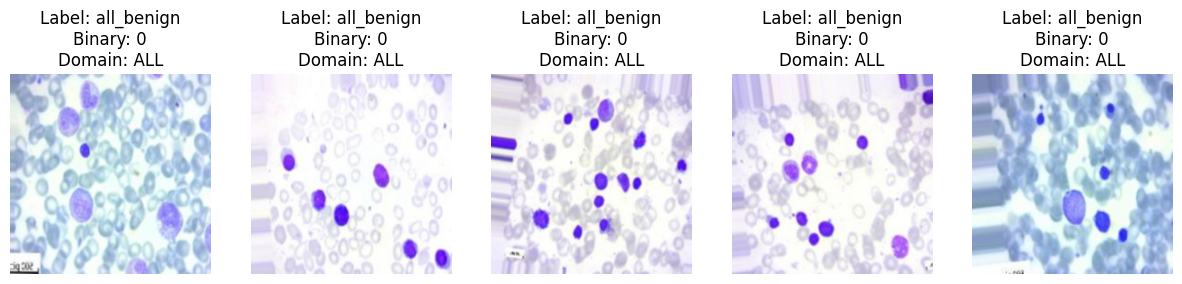

In [13]:
# Display the first 5 images with their labels
num_display = 5
fig, axes = plt.subplots(1, num_display, figsize=(15, 5))
for i in range(num_display):
    axes[i].imshow(images_np[i])
    axes[i].set_title(f"Label: {labels_np[i]}\nBinary: {binary_labels_np[i]}\nDomain: {domain_labels_np[i]}")
    axes[i].axis('off')
    

In [14]:
from torchvision import transforms
from branched_resnet_v2 import CustomImageDataset
import numpy as np


def preprocess_multicancer_to_custom_dataset(
    images,
    labels1,
    labels2,
    domain_text=None,
    domain_id=None,
    include_domains=None,
    sub_domain_text=None,
    sub_domain_id=None,
    include_subdomains=None,
    normalize=True,
    shuffle=True,
    seed=42,
):
    """
    Create a CustomImageDataset from arrays prepared in this notebook, with optional
    domain and subdomain filtering, and also return aligned text labels.

    Parameters
    - images: numpy array of shape (N, H, W, 3) or (N, H, W); dtype uint8/float.
    - labels1: array-like of shape (N,), int labels for primary task (e.g., class ids).
    - labels2: array-like of shape (N,), int labels for secondary task (e.g., domain ids or binary).
    - domain_text: optional array-like of shape (N,) with string domain names per sample.
    - domain_id: optional array-like of shape (N,) with integer domain ids per sample.
    - include_domains: None (no filtering) OR list[str] (by domain_text) OR list[int] (by domain_id)
      to include in the dataset.
    - sub_domain_text: optional array-like of shape (N,) with string subdomain/class names per sample.
    - sub_domain_id: optional array-like of shape (N,) with integer subdomain ids per sample.
    - include_subdomains: None (no filtering) OR list[str] (by sub_domain_text) OR list[int] (by sub_domain_id)
      to include in the dataset.
    - normalize: when True, apply torchvision Normalize(mean=0.5, std=0.5) to map to roughly [-1, 1].
    - shuffle: shuffle samples consistently across arrays.
    - seed: RNG seed for shuffling.

    Returns
    - dataset: CustomImageDataset
    - domain_text_list: list[str] aligned with dataset samples indicating sample domains
    - sub_domain_text_list: list[str] aligned with dataset samples indicating sample subdomains/classes
    """
    # Coerce to numpy arrays and basic validation
    images = np.asarray(images)
    labels1 = np.asarray(labels1, dtype=np.int64).reshape(-1)
    labels2 = np.asarray(labels2, dtype=np.int64).reshape(-1)

    n = len(images)
    if not (n == len(labels1) == len(labels2)):
        raise ValueError("images, labels1, and labels2 must have the same length")

    if domain_text is not None:
        domain_text = np.asarray(domain_text).reshape(-1)
        if len(domain_text) != n:
            raise ValueError("domain_text length must match images length")
    if domain_id is not None:
        domain_id = np.asarray(domain_id, dtype=np.int64).reshape(-1)
        if len(domain_id) != n:
            raise ValueError("domain_id length must match images length")

    if sub_domain_text is not None:
        sub_domain_text = np.asarray(sub_domain_text).reshape(-1)
        if len(sub_domain_text) != n:
            raise ValueError("sub_domain_text length must match images length")
    if sub_domain_id is not None:
        sub_domain_id = np.asarray(sub_domain_id, dtype=np.int64).reshape(-1)
        if len(sub_domain_id) != n:
            raise ValueError("sub_domain_id length must match images length")

    # Optional domain filtering
    mask = np.ones(n, dtype=bool)
    if include_domains is not None:
        if len(include_domains) == 0:
            raise ValueError("include_domains provided but empty")
        first_item = include_domains[0]
        if isinstance(first_item, str):
            if domain_text is None:
                raise ValueError("include_domains is list[str], but domain_text was not provided")
            mask &= np.isin(domain_text, include_domains)
        else:
            if domain_id is None:
                raise ValueError("include_domains is list[int], but domain_id was not provided")
            mask &= np.isin(domain_id, include_domains)

    # Optional subdomain filtering
    if include_subdomains is not None:
        if len(include_subdomains) == 0:
            raise ValueError("include_subdomains provided but empty")
        first_item = include_subdomains[0]
        if isinstance(first_item, str):
            if sub_domain_text is None:
                raise ValueError("include_subdomains is list[str], but sub_domain_text was not provided")
            mask &= np.isin(sub_domain_text, include_subdomains)
        else:
            if sub_domain_id is None:
                raise ValueError("include_subdomains is list[int], but sub_domain_id was not provided")
            mask &= np.isin(sub_domain_id, include_subdomains)

    if not np.any(mask):
        raise ValueError("Filtering excluded all samples; no data remains.")

    # Apply mask
    images = images[mask]
    labels1 = labels1[mask]
    labels2 = labels2[mask]
    filtered_domain_text = (domain_text[mask] if domain_text is not None else None)
    filtered_sub_domain_text = (sub_domain_text[mask] if sub_domain_text is not None else None)

    # Optional shuffling
    if shuffle:
        rng = np.random.default_rng(seed)
        perm = rng.permutation(len(images))
        images = images[perm]
        labels1 = labels1[perm]
        labels2 = labels2[perm]
        if filtered_domain_text is not None:
            filtered_domain_text = filtered_domain_text[perm]
        if filtered_sub_domain_text is not None:
            filtered_sub_domain_text = filtered_sub_domain_text[perm]

    # Build a safe transform for RGB arrays
    tfs = [transforms.ToTensor()]
    if normalize:
        tfs.append(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))
    transform = transforms.Compose(tfs)

    dataset = CustomImageDataset(images=images, labels1=labels1, labels2=labels2, transform=transform)

    # Prepare return text lists
    if filtered_domain_text is None:
        domain_text_list = [""] * len(dataset)
    else:
        domain_text_list = [str(x) for x in filtered_domain_text.tolist()]

    if filtered_sub_domain_text is None:
        sub_domain_text_list = [""] * len(dataset)
    else:
        sub_domain_text_list = [str(x) for x in filtered_sub_domain_text.tolist()]

    return dataset, domain_text_list, sub_domain_text_list

In [15]:
# Build datasets from the saved arrays
# Primary labels: class_ids_np; Secondary labels: domain_ids_np (or switch to binary_labels_np if needed)

# Ensure variables exist by reusing from previous cells
try:
    images_np
    class_ids_np
    domain_labels_np
    domain_ids_np
    labels_np
except NameError:
    raise RuntimeError("Expected variables images_np, class_ids_np, domain_labels_np, domain_ids_np, labels_np to be defined above.")

# Example: include only certain domains by name or id
# include_domains = ["ALL", "BREAST"]  # by name, if those domains exist in your data
include_domains = ['Lung and Colon Cancer', 'Breast Cancer', 'Kidney Cancer']  # set to a list to filter

# Example: include subdomains (class names) by text, using labels_np which has the original class strings
include_subdomains = None  # e.g., ["all_benign", "breast_benign"]

# Create dataset (using domain ids for labels2)
mc_dataset, mc_domain_text, mc_subdomain_text = preprocess_multicancer_to_custom_dataset(
    images=images_np,
    labels1=class_ids_np,
    labels2=binary_labels_np,
    domain_text=domain_labels_np,
    domain_id=domain_ids_np,
    include_domains=include_domains,
    sub_domain_text=labels_np,
    sub_domain_id=None,
    include_subdomains=include_subdomains,
    normalize=True,
    shuffle=True,
    seed=42,
)

# Quick sanity check: length, sample keys, and domain/subdomain text for that sample
print(len(mc_dataset))
sample = mc_dataset[0]
print({k: (v.shape if hasattr(v, 'shape') else v) for k, v in sample.items()})
print("domain_text[0]:", mc_domain_text[0])
print("subdomain_text[0]:", mc_subdomain_text[0])

45000
{'pixel_values': torch.Size([3, 224, 224]), 'labels1': 15, 'labels2': 0}
domain_text[0]: Lung and Colon Cancer
subdomain_text[0]: colon_bnt
{'pixel_values': torch.Size([3, 224, 224]), 'labels1': 15, 'labels2': 0}
domain_text[0]: Lung and Colon Cancer
subdomain_text[0]: colon_bnt


In [16]:
# Save the mc_dataset, mc_domain_text, and mc_subdomain_text to a .npz file
import os
import numpy as np

# Extract arrays from dataset
save_images = mc_dataset.images
save_labels1 = mc_dataset.labels1
save_labels2 = mc_dataset.labels2
save_domain_text = np.array(mc_domain_text, dtype='U')
save_sub_domain_text = np.array(mc_subdomain_text, dtype='U')

# Ensure output directory exists
out_dir = os.path.join('data', 'multi_cancer')
os.makedirs(out_dir, exist_ok=True)

# Choose a filename (you can change this as needed)
out_path = os.path.join(out_dir, 'adenocarcinoma_dataset.npz')

# Save compressed npz
np.savez_compressed(
    out_path,
    images=save_images,
    labels1=save_labels1,
    labels2=save_labels2,
    domain_text=save_domain_text,
    sub_domain_text=save_sub_domain_text,
)

print(f"Saved dataset to {out_path}")
print({
    'images': save_images.shape,
    'labels1': save_labels1.shape,
    'labels2': save_labels2.shape,
    'domain_text': save_domain_text.shape,
    'sub_domain_text': save_sub_domain_text.shape,
})

Saved dataset to data\multi_cancer\adenocarcinoma_dataset.npz
{'images': (45000, 224, 224, 3), 'labels1': (45000,), 'labels2': (45000,), 'domain_text': (45000,), 'sub_domain_text': (45000,)}
